# Procesamiento Digital de Señales <img src="./logo_UTN.svg" align="right" width="150"/>
## Alumno: Emanuel Olay
### TP de Aplicación

## 1. Introducción
> ### ¿Por qué es útil?
El ritmo respiratorio (**RR**) es una medicion importante para el diagnostico de la salud, ya que es un parametro muy sensible respecto de la deterioracion del estado de salud del paciente.<br>
Si la medicion diera por fuera de los limites esperables para la edad y condicion del paciente esto podria ayudar a identificar signos de neumonia, septicemia, hipercarbia y embolias pulmonares.Por ejemplo, un ritmo respiratorio elevado puede predecir un paro cardiaco, a su vez puede indicar disfuncionalidades respiratorias.<br>
Y como consecuencia el ritmo respiratorio se mide cada 4 a 6 horas en pacientes hospitalizados de gravedad.<br>
> ### Aplicación en la vida cotidiana
El ritmo respiratorio se suele medir de forma manual mediante el conteo de los movimientos de inhalacion y exhalacion de la caja toraxica (fuera de cuidados intesivos). Este es un procedimiento arduo y extenso sin mencionar impreciso.<br>
Esto se podria solucionar implementando algoritmos que estimen el ritmo respiratorio por medio del analisis de parametros no intrusivos como por ejemplo el ritmo cardiaco.<br>
La estimación respiratoria desde el electrocardiograma (**ECG**) se podria realizar mediante dispositivos cotidianos como por ejemplo, los smart watches que hoy en dia en su mayoria perciben los latidos. 


*[1] van Gent P, Farah H, van Nes N, van Arem B. HeartPy: A novel heart rate algorithm for the analysis of noisy signals. Transportation research part F: traffic psychology and behaviour. 2019 Oct 1;66:368-78.<br>
[2] S. Khreis, D. Ge, H. A. Rahman and G. Carrault, "Breathing Rate Estimation Using Kalman Smoother With Electrocardiogram and Photoplethysmogram," in IEEE Transactions on Biomedical Engineering, vol. 67, no. 3, pp. 893-904, March 2020, doi: 10.1109/TBME.2019.2923448.*


In [3]:
#%% Imports

# import warnings
# warnings.filterwarnings('ignore')

import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import scipy as sp
import scipy.signal as sig
from scipy.fft import fft, fftfreq, fftshift
from pandas import DataFrame
from IPython.display import HTML
plt.close('all')

width=15
height=5
plt.rcParams['figure.figsize'] = [width, height]

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

In [38]:
#%% Un par de funciones

#elimino algo del array que no me gusta

def quito_dato(array,dato):
    array = [x for x in array if x != dato]
    return array


# Normalización

def normalizacion(signal):
    maximo = np.amax(np.abs(signal))
    return signal/maximo

#funcion que filtra y calcula el ritmo para el ecg que le pase.
#No esta pensada para mostrar los graficos pero no me costaba mucho agregar la posibilidad.
#ecg es la se;al a partir de la cual vamos a trabajar.
#resp_ref es la se;al objetivo a obtener contra lo cual comparamos.
#El parametro print nos indica distintos graficos que querramos ver.
def calculo_ritmo_respiratorio(ecg,resp_ref,fs=0,p_print='Nada'):
    ##Verifico recibir los parametros correctos
    if fs<=0:
        print('No se ingreso una fs valida')
        return
    if p_print == 'Nada':  
        pass
        #print('Elegiste no imprimir nada')
######Hago mi interpolacion
    # Extract R-peaks locations
    _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=fs)
    
    detecciones=rpeaks['ECG_R_Peaks']
    
    muestras=ecg.size
    ##el tiempo empieza en 0 termina en muestras/fs y tiene num puntos en el medio
    t = np.linspace(0, muestras+detecciones[0],num=detecciones.size,endpoint=True)
    ##f2 es mi funcion que interpola para t y los puntos R del ecg con una cubica
    f2 = sp.interpolate.interp1d(t, ecg[detecciones], kind='cubic')
    ##el tiempo empieza en 0 termina en muestras/fs y tiene num puntos en el medio
    tnew = np.linspace(0, muestras, num=muestras, endpoint=True)
    #Creo mi extraccion con la funcion interpoladora
    extraccion=f2(tnew)
    #Desfaso respecto del primer pico R que encuentro
    extraccion=f2(tnew + rpeaks['ECG_R_Peaks'][0])
    #Le quito la media que le genera la funcion interpoladora para ponerlo lo mas cerca de cero posible
    extraccion= extraccion - np.mean(extraccion)
    
#######Empiezo a filtrar
    #Plantilla pasa altos
    
    f_paso=4/60 #respiraciones por segundo 0.0666
    f_stop=0.006
    #Ganancias en las bandas
    gpass = 0.5
    gstop = 28
    sos_HP=sig.iirdesign(wp=f_paso*2*np.pi,
                         ws=f_stop*2*np.pi,gpass=gpass,gstop=gstop,analog=False,
                         ftype='cheby1',output='sos',fs=fs)
    #####filtro mi extraccion para quitar frecuencias que se hayan agregado
    y_HP= sig.sosfiltfilt(sos_HP, extraccion)
    y_HP_ref= sig.sosfiltfilt(sos_HP, resp_ref)
    
    #Plantilla pasa bajos

    f_paso=64/60  #respiraciones por segundo 1.066
    f_stop=1.5
    
    gpass = 0.5
    gstop = 30
    sos_LP=sig.iirdesign(wp=f_paso*2*np.pi,
                         ws=f_stop*2*np.pi,gpass=gpass,gstop=gstop,analog=False,
                         ftype='cheby1',output='sos',fs=fs)
    #####filtro la senal contra la salida anterior
    y_LP= sig.sosfiltfilt(sos_LP, y_HP)
    y_LP_ref= sig.sosfiltfilt(sos_LP, y_HP_ref)
    
    #Plantilla Notch

    b,a=sig.iirnotch(w0=50,Q=1.5,fs=fs)
    #####filtro la senal contra la salida anterior
    y= sig.filtfilt(b,a, y_LP)
    y_ref= sig.filtfilt(b,a, y_LP_ref)
#######Fin del Filtrado

#######Calculo del ancho de banda a partir del periodograma de Welch
    npad=muestras*10
    f_welch_ref_o,Pxx_ref_o = sig.welch(resp_ref,fs=fs, nperseg=y_ref.size/4,window='bartlett',nfft=npad)
    f_welch_ref,Pxx_ref = sig.welch(y_ref,fs=fs, nperseg=y_ref.size/4,window='bartlett',nfft=npad)
    f_welch_y,Pxx_y = sig.welch(y,fs=fs, nperseg=y.size/4,window='bartlett',nfft=npad)
#######FIN Calculo de Welch

#######Calculo de la FFT
    # sample spacing
    T = 1.0 / fs
    fft_y=fft(y,n=npad)
    fft_ref=fft(y_ref,n=npad)
    fft_ref_o=fft(resp_ref,n=npad)
    #Agrego el metodo del neurokit
    van = nk.ecg_rsp(ecg, sampling_rate=fs)
    fft_van=fft(van,n=npad)
    #Eje de frecuencia
    xf = fftfreq(npad, T)[:npad//2]
#######FIN Calculo de la FFT

#######Imprimo los resultados pedidos
    if p_print == 'Interpolacion':
        plt.figure(1)
        plt.subplot(2,1,1)
        plt.plot(normalizacion(extraccion),'b-',label='Mi extraccion')
        plt.plot(normalizacion(resp_ref),'r-',label='Referencia')
        van = nk.ecg_rsp(ecg, sampling_rate=fs)
        plt.plot(normalizacion(van),'g-',label='Van Gent et al.')        
        plt.title('Respiraciones')
        plt.grid(True)
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(normalizacion(ecg))
        # Visualize R-peaks in ECG signal
        for xc in detecciones:
            plt.axvline(x=xc, color='r', linestyle=':')
        plt.title('Detecciones de picos R')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
    if p_print == 'Plantilla HP':
        ##Muestro el filtro
        plt.figure(2)
        w, h = sig.sosfreqz(sos_HP,fs=fs)    
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.plot(w, 20 * np.log10(np.abs(h)))
        print('Las plantillas no les gusta mucho frecuencias tan bajas y suelen hacer cosas raras')
    if p_print == 'Plantilla LP':
        ##Muestro el filtro
        plt.figure(3)
        w, h = sig.sosfreqz(sos_LP,fs=fs)
        ##tiene pinta
        plt.plot(w, 20 * np.log10(np.abs(h)))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.xlim(-0.2,10)
        plt.ylim(-10,2)
        print('Las plantillas no les gusta mucho frecuencias tan bajas y suelen hacer cosas raras')
    if p_print == 'Plantilla Notch':
        ##Muestro el filtro
        plt.figure(4)
        w, h = sig.freqz(b,a,fs=fs)
        ##Se podria mejorar el notch pero meh
        plt.plot(w, 20 * np.log10(np.abs(h)))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.xlim(0,100)
    if p_print == 'Salida HP':
        #Imprimo el resultado
        plt.figure(5)
        plt.subplot(3,1,1)
        plt.plot(normalizacion(y_HP),'b-',label='Mi extraccion')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.title('Salida del Filtro Pasa Altos')
        plt.grid(True)
        plt.legend()
        plt.subplot(3,1,2)
        plt.plot(normalizacion(y_HP_ref),'r-',label='Referencia filtrada')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.grid(True)
        plt.legend()
        plt.subplot(3,1,3)
        plt.plot(normalizacion(resp_ref),'k-',label='Referencia')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.grid(True)
        plt.legend()
    if p_print == 'Salida LP':
        #Imprimo el resultado
        plt.figure(6)
        plt.subplot(3,1,1)
        plt.plot(normalizacion(y_LP),'b-',label='Mi extraccion')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.title('Salida del Filtro Pasa Bajos')
        plt.grid(True)
        plt.legend()
        plt.subplot(3,1,2)
        plt.plot(normalizacion(y_LP_ref),'r-',label='Referencia filtrada')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.grid(True)
        plt.legend()
        plt.subplot(3,1,3)
        plt.plot(normalizacion(resp_ref),'k-',label='Referencia')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.grid(True)
        plt.legend()
        print('La salida del LP es despues de filtrar por el HP')
    if p_print == 'Salida Notch':
        #Imprimo el resultado
        plt.figure(7)
        plt.subplot(3,1,1)
        plt.plot(normalizacion(y),'b-',label='Mi extraccion')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.title('Salida del Filtro Notch')
        plt.grid(True)
        plt.legend()
        plt.subplot(3,1,2)
        plt.plot(normalizacion(y_ref),'r-',label='Referencia filtrada')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.grid(True)
        plt.legend()
        plt.subplot(3,1,3)
        plt.plot(normalizacion(resp_ref),'k-',label='Referencia')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.grid(True)
        plt.legend()
    if p_print == 'BW_1':
        plt.figure(8)
        plt.subplot(1,3,1)
        plt.plot(f_welch_y,(Pxx_y/np.amax(Pxx_y)),'b-',label='Mi extraccion')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('$PDS$[$V^{2}/Hz$]')
        plt.ylim(-0.2,1.2)
        plt.xlim(0,1)
        plt.legend()
        plt.subplot(1,3,2)
        plt.plot(f_welch_ref,(Pxx_ref/np.amax(Pxx_ref)),'r-',label='Ref filtrada')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('$PDS$[$V^{2}/Hz$]')
        plt.ylim(-0.2,1.2)
        plt.xlim(0,1)
        plt.legend()
        plt.subplot(1,3,3)
        plt.plot(f_welch_ref,(Pxx_ref/np.amax(Pxx_ref)),'k-',label='Ref Original')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('$PDS$[$V^{2}/Hz$]')
        plt.ylim(-0.2,1.2)
        plt.xlim(0,1)
        plt.legend()
        
    if p_print == 'BW_2': 
        corte_energia = 0.95
        Pot_ref = np.cumsum(Pxx_ref)/np.sum(Pxx_ref)
        Pot = np.cumsum(Pxx_y)/np.sum(Pxx_y)
        corte_ref = np.where(Pot_ref >corte_energia)[0][0]
        corte = np.where(Pot >corte_energia)[0][0]
        plt.figure(9)
        plt.subplot(1,2,1)
        plt.plot(f_welch_ref_o,Pxx_ref_o/np.amax(Pxx_ref_o), 'k')
        plt.fill_between(f_welch_ref_o, 0, Pxx_ref_o/np.amax(Pxx_ref_o), where = f_welch_ref_o < f_welch_ref_o[corte_ref], color='red')
        plt.title('Ancho de banda donde se concentra el {:3.0f}% de la energia en la referencia/ mi extraccion'.format(corte_energia*100))
        plt.xlabel('Frecuencia [Hz]')
        plt.ylabel('PSD [$V^{2}/Hz$]')
        plt.xlim(0,1.2)
        
        plt.annotate(   "BW_n = {:3.1f} Hz".format(f_welch_ref_o[corte_ref]),
                        xy=(f_welch_ref_o[corte_ref], Pxx_ref_o[corte_ref]/np.amax(Pxx_ref_o)),
                        xytext=(-20,20),
                        textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle='->')
        )
        
        plt.subplot(1,2,2)
        plt.plot(f_welch_y,Pxx_y/np.amax(Pxx_y), 'k')
        plt.fill_between(f_welch_y, 0, Pxx_y/np.amax(Pxx_y), where = f_welch_y < f_welch_y[corte], color='blue')
        #plt.title('Ancho de banda donde se concentra el {:3.0f}% de la energia en mi extraccion'.format(corte_energia*100))
        plt.xlabel('Frecuencia [Hz]')
        plt.ylabel('PSD [$V^{2}/Hz$]')
        plt.xlim(0,1.2)
        
        plt.annotate(   "BW_n = {:3.1f} Hz".format(f_welch_y[corte]),
                        xy=(f_welch_y[corte], Pxx_y[corte]/np.amax(Pxx_y)),
                        xytext=(-20,20),
                        textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle='->')
        )
    if p_print == 'FFT':
        plt.figure(10)
        plt.subplot(3,1,1)
        plt.plot(xf, normalizacion(np.abs(fft_y[0:npad//2])),'b-',label='Mi extraccion')
        plt.axvline(xf[np.argmax(np.abs(fft_y[0:npad//2]))], color='r', linestyle=':')
        plt.title('FFT de las Señales')
        plt.xlabel('Frecuencia [Hz]')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        
        plt.xlim(0,1.4)
        plt.legend()
        plt.subplot(3,1,2)
        plt.plot(xf, normalizacion(np.abs(fft_ref[0:npad//2])),'r-',label='Ref filtrada')
        plt.axvline(xf[np.argmax(np.abs(fft_ref[0:npad//2]))], color='r', linestyle=':')
        plt.xlabel('Frecuencia [Hz]')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        
        plt.xlim(0,1.4)
        plt.legend()
        plt.subplot(3,1,3)
        plt.plot(xf,normalizacion(np.abs(fft_ref_o[0:npad//2])),'k-',label='Ref Original')
        plt.axvline(xf[np.argmax(np.abs(fft_ref_o[0:npad//2]))], color='r', linestyle=':')
        plt.xlabel('Frecuencia [Hz]')
        #Con estas dos sentencias escondo los ticks de los ejes
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.xlim(0,1.4)
        plt.legend()
        plt.show()
    
    ritmo_extraccion = xf[np.argmax(np.abs(fft_y[0:npad//2]))]
    ritmo_original = xf[np.argmax(np.abs(fft_ref_o[0:npad//2]))]
    ritmo_van = xf[np.argmax(np.abs(fft_van[0:npad//2]))]
    # input("Press Enter to continue...")
    return ritmo_extraccion,ritmo_original,ritmo_van

# Condiciones de las mediciones
> Para la aplicacion del algoritmo se tomaron mediciones conjuntas de ECG y respiracion, durante una hora sobre pacientes en reposo escuchando musica clasica.<br>
Con un sampling $F_s=5Khz$ , por la naturaleza de la señal se tomaron 50K muestras que equivaldrian a 10 segundos con el objetivo de englobar varios ciclos de inhalacion y exhalacion.

In [5]:
# %%Variables
###################################################
#Por el readme.txt interpreto que se sampleo a 5Khz
fs= 5000 #Hz
path2 = r"E:\Facultad\PDS\combined-measurement-of-ecg-breathing-and-seismocardiograms-1.0.0\m001"
record2 = wfdb.rdrecord(path2)
###Para 5Khz, 50000 son unos 10 segundos que nos darian unas 3-4 respiraciones
muestras = 50000

ecg = record2.p_signal[::,1]
resp_ref = record2.p_signal[::,2]

## 2. Metodologia
> "Los algoritmos de estimacion respiratoria consisten en hasta 5 pasos.
El rol de cada uno de los pasos son los siguientes.<br>**1) Extraccion de la señal respiratoria(s)**: consiste en extraer una o mas señales dominadas por una modulacion respiratoria.<br>2) Fusion de las señales respiratorias: multiples señales respiratorias puede ser fusionadas para resultar en una señal respiratoria(opcional).<br>3) Estimacion del RR(s): consiste en estimar el RR a partir de una ventana de la señal respiratoria.<br>4) Fusionar RR(s): multiples estimaciones de RR puede ser fusionadas para obtener una estimacion final(opcional).<br>5) Evaluacion de calidad: se hace para rechazar o mitigar posibles impresiciones en las estimaciones(opcional)."
### Extraccion de la señal respiratoria(s)
> Hay dos metodos principales para la extraccion de la señal respiratoria:<br> * *Tecnicas basadas en filtros<br> * Tecnicas basadas en las caracteristicas morfologicas* <br> En ambos metodos se utilizan los siguientes pasos: <br>1. Extraccion en base a las caracteristicas morfologicas desde un ECG previamente filtrado procedemos a una deteccion de los picos R del complejo QRS y luego interpolamos para generar una señal de respiracion estimada<br>2. Eliminacion de frecuencias muy bajas, esto es esencialmente para no tener interferencia de elementos que no puedan ser respiraciones. Por ejemplo, no es esperable respirar menos de 4 veces por minuto.<br>3. Eliminacion de muy altas frecuencias, nuevamente no es esperable respirar mas de 65 veces por minuto.<br>4. Estimacion del RR, utilizando la transformada rapida de Fourier(**FFT**) identificamos el componente frecuencial relacionado al RR.<br>5. Revision de los resultados, haciendo uso de un analisis espectral con el periodograma de Welch podemos hallar el ancho de banda de la señal de forma tal de que nuestros resultados al menos queden acotados en esa banda.

*Charlton, P.H., Birrenkott, D.A., Bonnici, T., Pimentel, M.A., Johnson, A.E., Alastruey, J., Tarassenko, L., Watkinson, P.J., Beale, R. and Clifton, D.A., 2017. Breathing rate estimation from the electrocardiogram and photoplethysmogram: A review. IEEE reviews in biomedical engineering, 11, pp.2-20.*

## Demostracion de la interpolacion

Armamos una señal extraida del ECG a partir de la interpolacion de los picos del complejo QRS.<br>
Esto es un metodo que parte de la morfologia y las caracteristicas intrinsecas de la señal del ECG. 

In [6]:
#%%itero mi funcion para el histograma

#Total de iteraciones completas que puedo hacer sobre 1 ecg largo
iteraciones=(int(ecg.size/muestras))
#Para probar uso 10
# iteraciones=1
# Creo la matriz de resultados
w, h = 3, iteraciones
Matriz = np.zeros((h, w))


for i in range(iteraciones):
      ecg_recorte = ecg[i*(muestras):(i+1)*muestras]
      resp_recorte = resp_ref[i*(muestras):(i+1)*muestras]
      Matriz[i,:]=calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Nada')

(0.33, 0.38, 0.24)

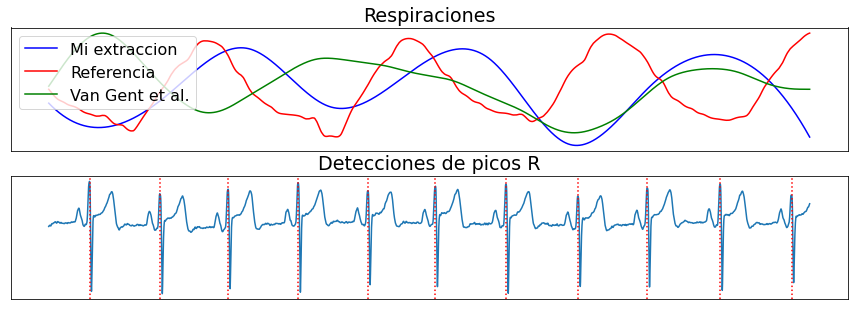

In [20]:
#%% Pruebo mi funcion
ecg_recorte = ecg[0:muestras]
resp_recorte = resp_ref[0:muestras]
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Interpolacion')

## Filtramos la señal extraida
> La interpolacion en general es muy suave por la cantidad de puntos que tenemos.De todas formas ploteamos las salidas de los filtros para demostrar que no afectan a la respiracion.<br>

Los filtros en cuestion son los siguientes:<br>
- un pasa altos para eliminar la continua y frecuencias respiratorias que no consideramos posibles por lo bajas que son(menores a 4 respiraciones por minuto).
- un pasa bajos para eliminar altas frecuencias que no consideremos posibles(mayores a 64 respiraciones por minuto).
- un notch que quite el ruido de linea de 50 Hz

*Estas decisiones fueron basadas en W. Karlen et al., “Respiratory rate assessment from photoplethysmographic imaging,” in Proc. Conf. Proc. Eng. Med. Biol. Soc., 2014,
pp. 5397–5400. [Online]. Available: http://doi.org/10.1109/EMBC.2014.
6944846*

(0.33, 0.38, 0.24)

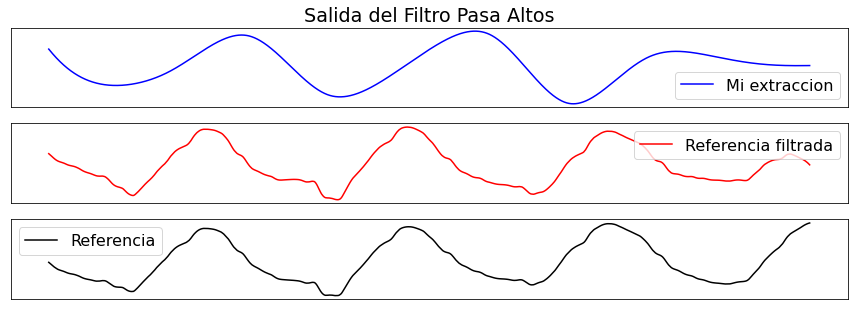

In [22]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Salida HP')

La salida del LP es despues de filtrar por el HP


(0.33, 0.38, 0.24)

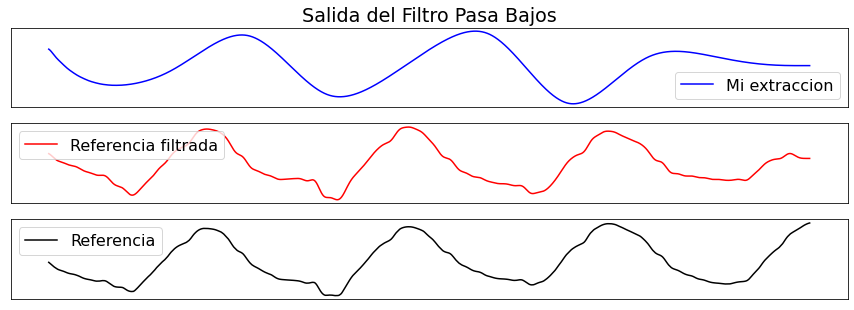

In [23]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Salida LP')

(0.33, 0.38, 0.24)

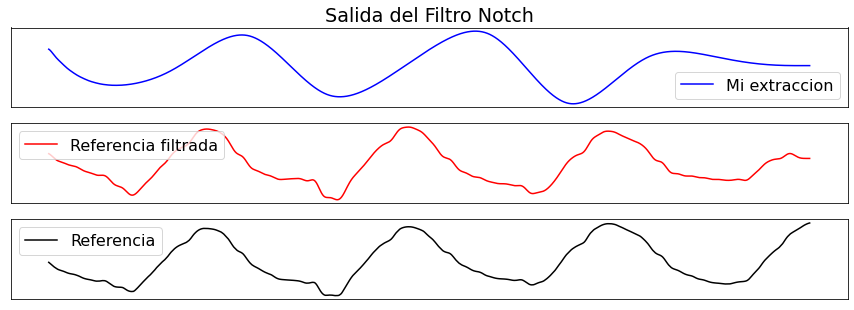

In [24]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Salida Notch')

# Demostracion del Ancho de Banda
A continuacion vamos a mostrar por el metodo del periodograma de Welch en que ancho de banda se encuentra el 95% de la energia pero constatar que la estimacion final se encuentre al menos dentro de ese ancho de banda.<br>

(0.33, 0.38, 0.24)

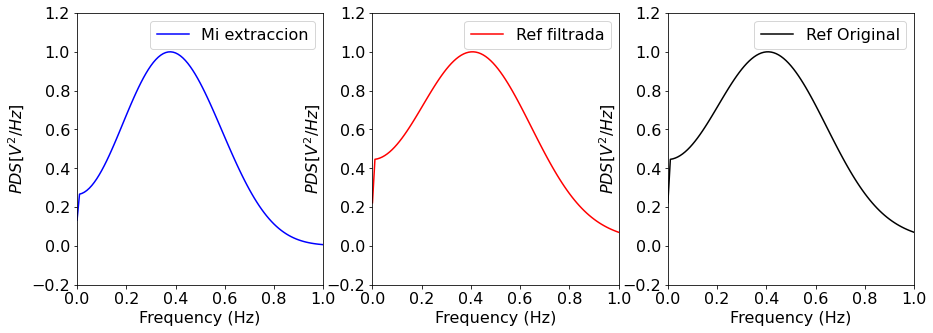

In [29]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='BW_1')

(0.33, 0.38, 0.24)

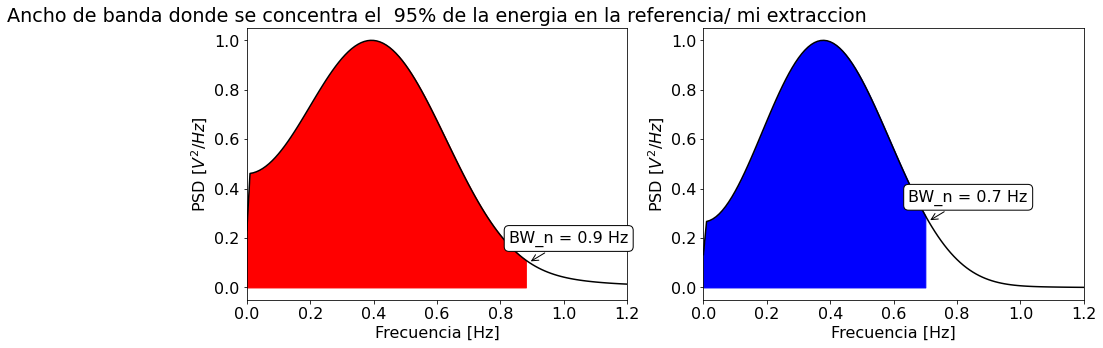

In [33]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='BW_2')

# Aproximacion de la frecuencia respiratoria
> A partir de lo expuesto hasta aca es evidente que nuestra informacion esta muy concentrada en banda y es aceptable aproximar a que la misma es unica en el pico de frecuencia que expondremos a continuacion.<br>

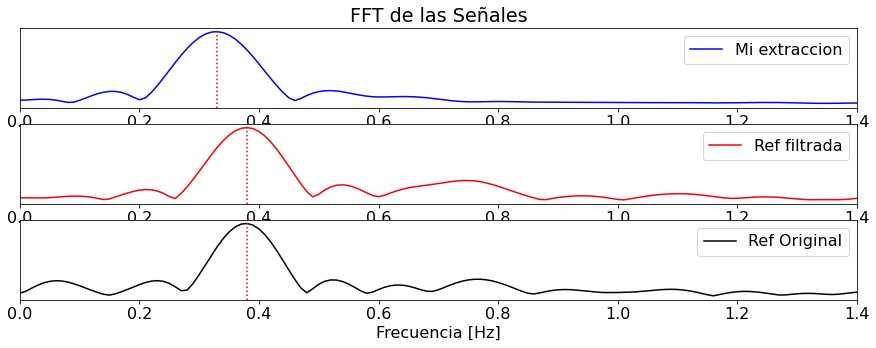

(0.33, 0.38, 0.24)

In [39]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='FFT')

# Repetimos el calculo de la frecuencia respiratoria
> El calculo anterior lo iteramos a lo largo de unas 250 extracciones y graficamos en histogramas sus resultados.<br>

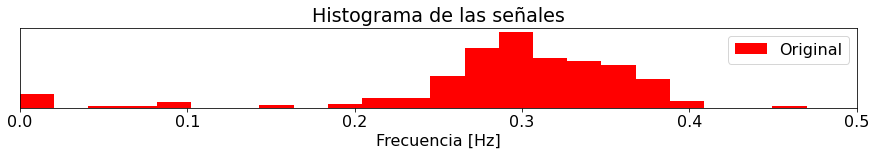

In [44]:
#%% Armo el histograma con la matriz
# Matriz[:,1] es la original yMatriz[:,0] es la mia
plt.figure(11)

plt.subplot(3,1,1)
plt.hist(Matriz[:,1],bins='auto',label='Original', color= 'Red')
plt.xlim(0,.5)
plt.title('Histograma de las señales')
plt.xlabel('Frecuencia [Hz]')
#Con estas dos sentencias escondo los ticks de los ejes
plt.gca().axes.get_yaxis().set_visible(False)
plt.legend()


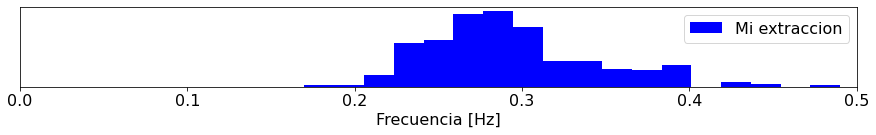

In [45]:
#%% Armo el histograma con la matriz
plt.subplot(3,1,2)
plt.hist(Matriz[:,0],bins='auto',label='Mi extraccion', color= 'Blue')
plt.xlim(0,.5)
plt.xlabel('Frecuencia [Hz]')
#Con estas dos sentencias escondo los ticks de los ejes
plt.gca().axes.get_yaxis().set_visible(False)
plt.legend()


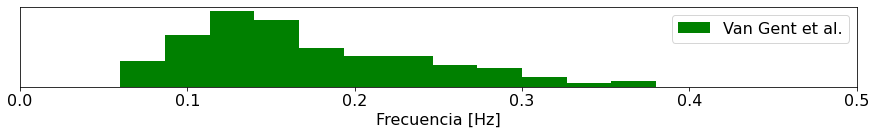

In [46]:
#%%
plt.subplot(3,1,3)
plt.hist(Matriz[:,2],bins='auto',label='Van Gent et al.', color= 'Green')
plt.xlim(0,.5)
plt.xlabel('Frecuencia [Hz]')
#Con estas dos sentencias escondo los ticks de los ejes
plt.gca().axes.get_yaxis().set_visible(False)
plt.legend()
plt.show()

# Calculo del sesgo y la varianza
> Comparacion del sesgo y la varianza de mi estimacion respecto de la estimacion que se hace en el nuerokit.<br>

In [14]:
#%%
#######################
#Calculo de sesgo y varianza
#######################

# media muestral: mu_a = 1/M.SUM{â_j} de 0 a M-1

E_extraccion = np.mean(Matriz[:,0])
E_original = np.mean(Matriz[:,1])
E_van = np.mean(Matriz[:,2])

#Sesgo: s = mu - a0

s_extraccion = E_extraccion - E_original
s_van = E_van - E_original

#Varianza: Var(x)=E[(X-mu)**2]

var_extraccion = np.var(Matriz[:,0])
var_van = np.var(Matriz[:,2])


# Muestro los datos

data = [[s_extraccion, var_extraccion],
        [s_van, var_van]
        ]

df = DataFrame(data,columns=['$s_a$', '$v_a$'],
                index=[  
                        'Mi extraccion',
                        'Van Gent et al.'
                      ])
HTML(df.to_html())

,$s_a$,$v_a$
Mi extraccion,0.002359,0.002534
Van Gent et al.,-0.121690,0.004662


# Conclusiones y comentarios:
> La aproximacion morfologica de la respiracion es apropiada para el calculo de la frecuencia respiratoria, no asi para su visualizacion. En caso de querer aproximar su visualizacion se deberia aproximar con mas puntos del ECG (en este trabajo se utilizo unicamente el punto R del complejo QRS) que aumentaria considerablemente el costo computacional.<br>
El filtrado de la frecuencia de linea en la extraccion es innecesaria ya que al tener pocos puntos para armar la señal esta interferencia es despreciable.<br>
El metodo implementado en esta presentacion es mas eficaz ya que reducimos tanto el sesgo como la varianza respecto de la implementacion del Neurokit.